In [1]:
push!(LOAD_PATH,"../../../ExoJulia/")
push!(LOAD_PATH,".")

4-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                
 "."                                                                                 

In [2]:
using ExoJulia
using Optim

In [3]:
using PyPlot

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read-in TTV data

In [4]:
ttv1_data = readdlm("../ttv_planet1.txt");
ttv2_data = readdlm("../ttv_planet2.txt");

In [5]:
# Reshape into 1d arrays
time1 = reshape(ttv1_data, length(ttv1_data));
time2 = reshape(ttv2_data, length(ttv2_data));

In [59]:
dt1 = time1[2:end] - time1[1:end-1];
dt2 = time2[2:end] - time2[1:end-1];

mdt1 = mean(dt1);
mdt2 = mean(dt2);

bestP1 = mdt1;
bestP2 = mdt2;

stdt1 = std(dt1);
stdt2 = std(dt2);

print("Inner planet period: ", mdt1, " +/- ", stdt1, "\n")
print("Outer planet period: ", mdt2, " +/- ", stdt2)

Inner planet period: 224.70076641863517 +/- 0.0022854502193227965
Outer planet period: 365.25630708152175 +/- 0.002178896306975526

# Plot Transit Times with Mean period subtracted off

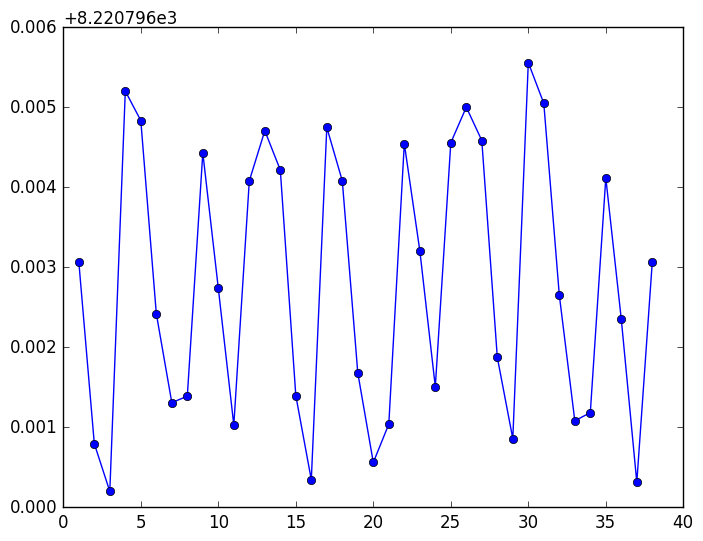

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32a2aa450>

In [75]:
a1 = ones(length(time1))
b1 = zeros(length(time1))
for i=1:length(time1)
    a1[i] = i*mdt1
    b1[i] = i
end

obs_ttv1 = time1 .- a1

plot(b1,obs_ttv1, "o-")

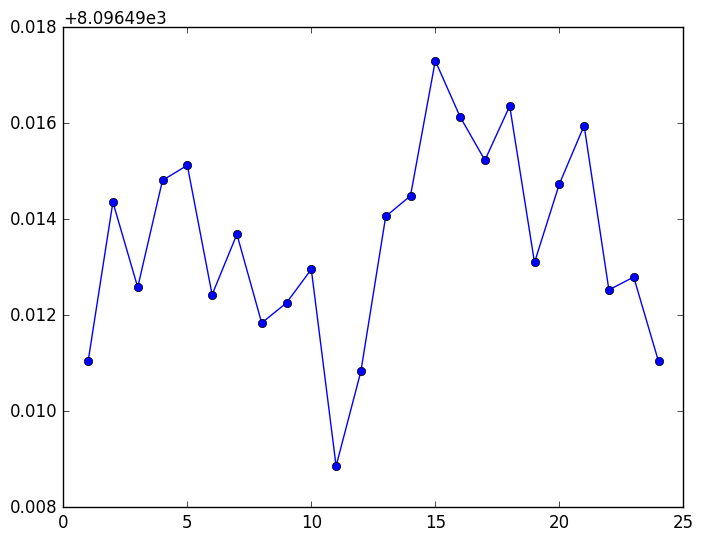

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32a664190>

In [76]:
a2 = ones(length(time2))
b2 = zeros(length(time2))
for i=1:length(time2)
    a2[i] = i*mdt2
    b2[i] = i
end

obs_ttv2 = time2 .- a2

plot(b2,obs_ttv2, "o-")

# Wrapper for `compute_ttv.jl`

In [9]:
include("../compute_ttv.jl")

TTVFaster

In [106]:
function two_planet_ttv_model(time1::Array{Float64, 1},
                              time2::Array{Float64, 1}, 
                              planet1::TTVFaster.Planet_plane_hk{Float64}, 
                              planet2::TTVFaster.Planet_plane_hk{Float64};
                              jmax::Int64=5)
    
    """
    # Planet 1 params
    MpMs1 = params[1]
    P1    = params[2]
    t01   = params[3]
    esw1  = params[4]
    ecw1  = params[5]
    
    # Planet 2 params
    MpMs2 = params[6]
    P2    = params[7]
    t02   = params[8]
    esw2  = params[9]
    ecw2  = params[10]
    """
    
    # Allocate memory for ttv's
    ttv1 = zeros(length(time1));
    ttv2 = zeros(length(time2));
    
    # Call compute_ttv! Note: modifies ttv1, ttv2 in place
    TTVFaster.compute_ttv!(jmax, planet1, planet2, time1, time2, ttv1, ttv2)

    return ttv1, ttv2
end 

two_planet_ttv_model (generic function with 2 methods)

In [275]:
function N_planet_ttv_model(data, params)
    
    # Number of planets
    N =  length(data[1,:])
    
    # Number of planets with transit data
    tmask = data[1,:] .> 0.0
    Nt = sum(tmask)
    
    # Allocate memory for ttv arrays
    ttv_list = []
    for i=1:length(tmask)
        if tmask[i]
            len = sum(data[:,i] .> 0)
            tmp = zeros(len)
            push!(ttv_list, tmp)
        end
    end    
    
    # Construct planet grid from params
    planets = construct_planets(params)
    
    # Loop over N(N-1) planets (No double counting)
    for i=1:N        
        for j=(i+1):N
            # Deconstruct data grid
            ti, tj = deconstruct_data_grid(data, i, j)
            # Call two-planet ttv
            ttvi, ttvj = two_planet_ttv_model(ti, tj, planets[i], planets[j])
            # Add ttvs if transiting
            if tmask[i]
                ttv_list[i] = ttv_list[i] .+ ttvi
            end
            if tmask[j]
                ttv_list[j] = ttv_list[j] .+ ttvj    
            end 
        end
    end 
    
    return ttv_list
end 

N_planet_ttv_model (generic function with 2 methods)

In [260]:
function construct_planets(params::Vector)
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params. Must be multiple of 5!")
        return Inf
    else
        N = Int(length(params) / 5)
        # Construct Planet grid
        plist = []
        for i=1:N
            push!(plist, TTVFaster.Planet_plane_hk(params[5*(i-1)+1], 
                                                   params[5*(i-1)+2], 
                                                   params[5*(i-1)+3], 
                                                   params[5*(i-1)+4],
                                                   params[5*(i-1)+5]))
        end 
    end 
    return plist
end

construct_planets (generic function with 1 method)

In [103]:
#planet1
MpMs1 = 0.001
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 0.001
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

planet_test = TTVFaster.Planet_plane_hk(MpMs2, P2, t02, esw2, ecw2)

p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];

In [104]:
typeof(planet_test)

TTVFaster.Planet_plane_hk{Float64}

In [12]:
ttv1, ttv2 = ttv_model(time1, time2, p0);

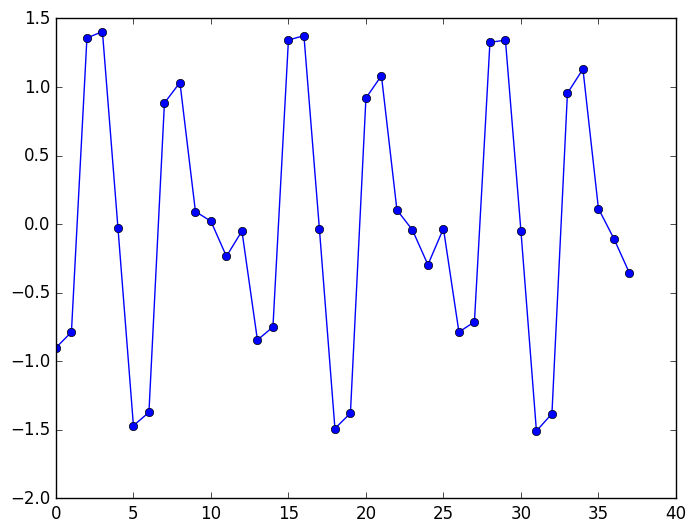

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326286710>

In [13]:
plot(ttv1, "o-")

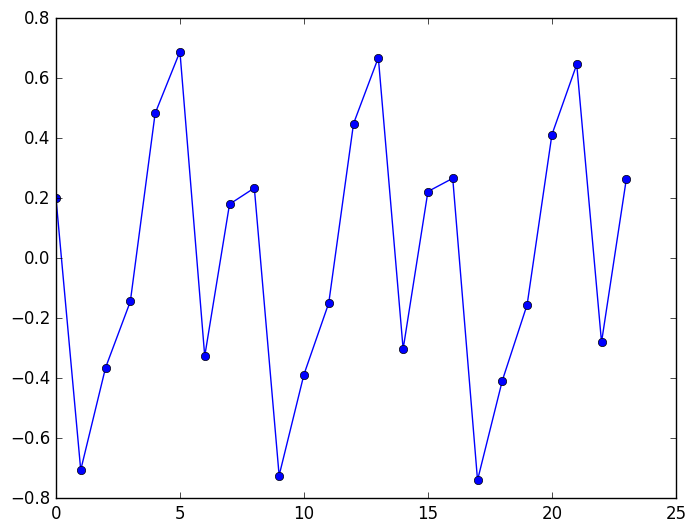

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31f8ed050>

In [14]:
plot(ttv2, "o-")

# Let's checkout `aimee`

In [15]:
include("aimee.jl")

est_burnin (generic function with 1 method)

In [83]:
(bestP1 - 0.001*bestP1), bestP1, (bestP1 + 0.001*bestP1)

(224.47606565221653,224.70076641863517,224.9254671850538)

In [278]:
function lnlike(data::Array{Float64,2},model::Function,params::Vector)
    # params = [MpMs1,P1,t01,esw1,ecw1,
    #           MpMs2,P2,t02,esw2,ecw2];
    
    # --- Hard-Bounds ---
    # Masses > 0
    if (params[1] < 0.0) || (params[6] < 0.0)
        return Inf
    end
    # Masses constrained by upper limit, say Mj/Ms
    # Periods > 0
    if (params[2] < 0.0) || (params[7] < 0.0)
        return Inf
    end
    # Periods constrained by known mean period
    if ( params[2] < (bestP1 - 0.001*bestP1) ) || ( params[2] > (bestP1 + 0.001*bestP1) )
        return Inf
    end
    if ( params[7] < (bestP2 - 0.001*bestP2) ) || ( params[7] > (bestP2 + 0.001*bestP2) )
        return Inf
    end
    # -1 < esin(w) & ecos(w) < 1
    if (params[4] < -1.0) || (params[4] > 1.0) || (params[5] < -1.0) || (params[5] > 1.0)
        return Inf
    end
    if (params[9] < -1.0) || (params[9] > 1.0) || (params[10] < -1.0) || (params[10] > 1.0)
        return Inf
    end
    
    # Deconstruct data grid
    ttv_data = deconstruct_data_grid(data);
    
    # Call model
    ttv_model = model(data, params);
    
    # Compute sum-square-diffs
    res = 0
    for i=1:length(ttv_data)
        res += sum((ttv_model[i] .- ttv_data[i]).^2);
    end 
    
    return res
end

lnlike (generic function with 1 method)

In [114]:
function construct_data_grid(t1, t2; N=2)
    if length(t1) > length(t2)
        n1 = length(t1)
        n2 = length(t2)
        x = t1
        y = t2
    else
        n1 = length(t2)
        n2 = length(t1)
        x = t2
        y = t1
    end
    
    dat = zeros(n1)
    
    # Populate y-grid
    for i=1:n2
        dat[i] = y[i]
    end
    
    # Preserve order
    if length(t1) > length(t2)
        data = [x dat]
    else
        data = [dat x]
    end
    
    # Add additional outer planets
    k = 2
    while k < N
        data = [data zeros(n1)]
        k += 1
    end
    
    return data
end

construct_data_grid (generic function with 1 method)

In [128]:
function deconstruct_data_grid(data::Array{Float64, 2}, i::Int64, j::Int64)
    
    N =  length(data[1,:])
    
    # Zero masks
    mask1 = data[:,i] .> 0.0
    mask2 = data[:,j] .> 0.0
    
    # Extract arrays from data matrix
    time1 = data[mask1,i]
    time2 = data[mask2,j]
    
    return time1, time2
end 

deconstruct_data_grid (generic function with 1 method)

In [274]:
function deconstruct_data_grid(data::Array{Float64, 2})
    # This function takes a 2d data array and returns a list of data with unqeual lengths
  
    # Number of planets
    N =  length(data[1,:])
    
    # Number of planets with transit data
    tmask = data[1,:] .> 0.0
    Nt = sum(tmask)
    
    # Allocate memory for ttv arrays
    ttv_list = []
    for i=1:length(tmask)
        if tmask[i]
            len = sum(data[:,i] .> 0)
            tmp = zeros(len)
            push!(ttv_list, tmp)
        end
    end    
    
    return ttv_list
end 

deconstruct_data_grid (generic function with 2 methods)

In [270]:
list = deconstruct_data_grid(data_in)

2-element Array{Any,1}:
 [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
 [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

In [272]:
list[2]

24-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [267]:
data_in = construct_data_grid(obs_ttv1, obs_ttv2, N=3);
data_in[1:10,:]

10x3 Array{Float64,2}:
 8220.8  8096.5   0.0
 8220.8  8096.5   0.0
 8220.8  8096.5   0.0
 8220.8  8096.5   0.0
 8220.8  8096.51  0.0
 8220.8  8096.5   0.0
 8220.8  8096.5   0.0
 8220.8  8096.5   0.0
 8220.8  8096.5   0.0
 8220.8  8096.5   0.0

In [142]:
t1, t2 = deconstruct_data_grid(data_in, 1, 2)
length(t1), length(t2)

(38,24)

In [96]:
function fit_model(nsteps::Int,in_data::Array{Float64,2};
    verbose::Bool=true)
    
    global data = in_data
    
    params = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];
    errors = [0.0005, 1.0, 1.0, 0.1, 0.1, 0.0005, 1.0, 1.0, 0.1, 0.1]
    

    return affine_inv_mcmc(nsteps,params,ttv_model,errors,verbose=verbose,lnlike=lnlike)
end

fit_model (generic function with 1 method)

In [88]:
N = 10000
pb, ll, nw, np = fit_model(N, data_in; verbose=false);

In [89]:
iburn = est_burnin(pb, nw, np, N)

10000

In [90]:
pavg = mean(vec(pb[1:nw,iburn:N,1]));
psig = std(vec(pb[1:nw,iburn:N,1]));
@printf "MpMs1: %8.4f +/- %8.4f\n" pavg psig

MpMs1:   0.2249 +/-   0.0347


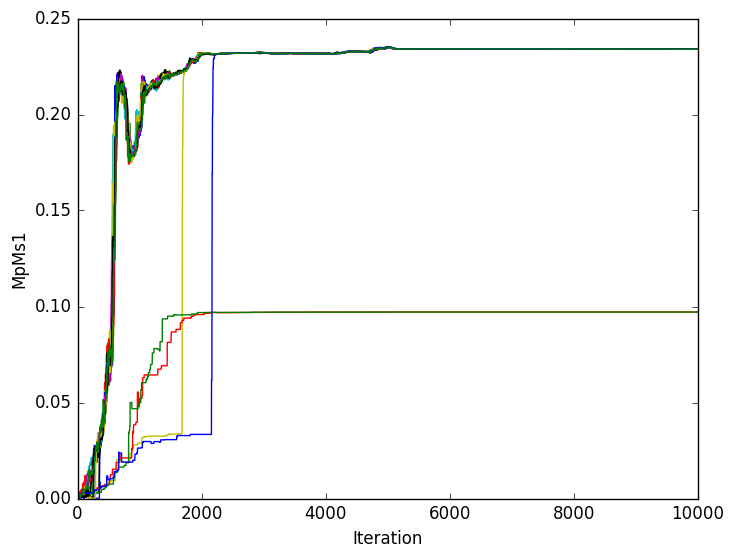

PyObject <matplotlib.text.Text object at 0x32af3ee90>

In [92]:
# Define names of parameters
names = ["MpMs1","P1","t01","esw1","ecw1","MpMs2","P2","t02","esw2","ecw2"];
# Create iteration grid for plot
x = collect(linspace(1, N, N))
which = 1
for i=1:nw
    plot(x, pb[i,:,which]')
end 
ylabel(names[which])
xlabel("Iteration")

In [73]:
bestP1

224.70076641863517

In [148]:
tup = (t1, t2)

([8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8  …  8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8],[8096.5,8096.5,8096.5,8096.5,8096.51,8096.5,8096.5,8096.5,8096.5,8096.5  …  8096.51,8096.51,8096.51,8096.51,8096.5,8096.5,8096.51,8096.5,8096.5,8096.5])

In [152]:
tup[2]

24-element Array{Float64,1}:
 8096.5 
 8096.5 
 8096.5 
 8096.5 
 8096.51
 8096.5 
 8096.5 
 8096.5 
 8096.5 
 8096.5 
 8096.5 
 8096.5 
 8096.5 
 8096.5 
 8096.51
 8096.51
 8096.51
 8096.51
 8096.5 
 8096.5 
 8096.51
 8096.5 
 8096.5 
 8096.5 

In [193]:
tup = (obs_ttv1, obs_ttv2, zeros(0))

([8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8  …  8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8,8220.8],[8096.5,8096.5,8096.5,8096.5,8096.51,8096.5,8096.5,8096.5,8096.5,8096.5  …  8096.51,8096.51,8096.51,8096.51,8096.5,8096.5,8096.51,8096.5,8096.5,8096.5],Float64[])

Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}

In [263]:
construct_planets(p0)

2-element Array{Any,1}:
 TTVFaster.Planet_plane_hk{Float64}(0.001,224.70076641863517,1.0,0.1,0.1)
 TTVFaster.Planet_plane_hk{Float64}(0.001,365.25630708152175,1.0,0.1,0.1)